# Imports and Constants:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from cycler import cycler
import itertools
from tqdm import trange, tqdm
plt.style.use(['science','ieee','notebook'])
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#9A0EEA'])
plt.rcParams.update({'font.serif': 'serif', 'font.family' : 'DeJavu Serif'})
plt.rcParams.update({
        'font.size': 21,
        'axes.labelsize': 21,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 16
    })

# Constants:
G = 6.67e-11
c = 3e8
hbar = 1.05e-34
solarMass = 1.9891e30
T_obs = 604800
frequencies = np.logspace(0,5,100000)
colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#9A0EEA']

# Graphing Code:

In [2]:
def plot_SNR(x_vals, SNR_list_vector, SNR_list_scalar, labels, xCutOff):
    
    # Create a graph that plots the SNR at every boson rest energy for a given black hole mass for different interferometer configurations
    
    fig, ax1 = plt.subplots(figsize=(10, 8))
    
    ax1.axhline(y=8, color = 'black', zorder=0, linestyle = 'dotted')
    
    for i, SNR in enumerate(SNR_list_scalar):
        ax1.plot(x_vals, SNR, zorder=0, linestyle='--', color=colors[i], alpha=0.65)
    
    for i, SNR in enumerate(SNR_list_vector):
        ax1.plot(x_vals, SNR, label=labels[i], zorder=0, color=colors[i])
    
    ax1.set_yscale('log')
    ax1.set_xscale('linear')
    ax1.set_ylim(1e-1)
    ax1.xaxis.tick_bottom()
    
    # Fetch the current y-axis limits after setting the scale
    y_min, y_max = plt.gca().get_ylim()
    
    # Define the region for shading (no superradiance) and fill it with light gray
    x_fill_zone = np.logspace(xCutOff, -10, 100000)
    ax1.fill_between(x_fill_zone, y_min, y_max, color='lightgray', label='No superradiance', zorder=0)
    
    def convert_to_frequency(X):
        return (64500 * (6.67e-11) * X * (1.9891e30) * (1.6e-19)) / (((3e8)**3) * (1.05e-34))
    
    # Function that makes secondary y labels be scientific notation
    def format_scientific_notation(value, precision=0):
        formatted = f"{value:.{precision}e}"
        base, exponent = formatted.split('e')
        exponent = int(exponent)
        if (round(float(base),1)==1.0):
            return f"$10^{{{exponent}}}$"
        else:
            return f"${base} \\times 10^{{{exponent}}}$"
        
    # Set lower and upper x-axes' ticks and labels
    xTicks = [1e-11,4e-11,7e-11,1e-10]
    xTickLabels = []
    ax1.set_xticks(xTicks)
    for tick in xTicks:
        xTickLabels.append(format_scientific_notation(tick,0))
    ax1.set_xticklabels(xTickLabels)
    ax2 = ax1.secondary_xaxis('top', functions=(convert_to_frequency, lambda x: x))
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format_scientific_notation(x, 0)))
    ax2.set_xlabel('Emission frequency (Hz)', labelpad=10)
    ax2.set_xticks([1e4,2e4,3e4,4e4])
        
    # Set all other ticks to point outwards
    ax1.tick_params(direction='out', which='both')
    ax2.tick_params(direction='out', which='both')
    
    # Remove tick marks on the top x-axis
    ax1.tick_params(axis='y', which='both', right=False)
    
    plt.grid(False)
    plt.gca().xaxis.grid(False, which='both')
    plt.gca().yaxis.grid(False, which='both')
    plt.xlabel("Boson rest energy (eV)")
    ax1.set_ylabel('SNR', labelpad=-8)
    plt.xlim(1e-11,1e-10)
    # plt.legend(frameon=True, loc='upper right', ncol=1)
    # plt.savefig('Boson Cloud SNR v. Mass graph.pdf',format='pdf', dpi=300)
    plt.show()
    return

# Simulation Code:

In [3]:
def strainVector(M, u, alpha, distance):
    
    mass = M*solarMass
    finalmass = 0.9*mass
    alphaf = (G*finalmass*u)/((c**3)*hbar) * (1.6e-19)
    chif = (4*alphaf)/(4*((alphaf)**2) + 1)
    
    hfv = (4e-24) * (M*0.1) * ((alpha/0.1)**5) * (1/distance) * ((0.7 - chif)/(0.1))
    
    return hfv

def strainScalar(M, u, alpha, distance):
    
    mass = M*solarMass
    finalmass = 0.9*mass
    alphaf = (G*finalmass*u)/((c**3)*hbar) * (1.6e-19)
    chif = (4*alphaf)/(4*((alphaf)**2) + 1)
    
    hfs = (8e-28) * (M*0.1) * ((alpha/0.1)**7) * (1/distance) * ((0.7 - chif)/(0.1))
    
    return hfs

In [4]:
def compute_SNR(S, M, u, dist):
    
    mass = M * solarMass
    vectorSNR = np.zeros_like(u)
    scalarSNR = np.zeros_like(u)

    for i in tqdm(range(len(u))):
        alpha = (G * mass * u[i]) / ((c**3) * hbar) * (1.6e-19)
        f_0 = 645 * (10 / M) * (alpha / 0.1)
        if alpha < 0.204:
            # Calculate ASD and PSD at specific boson cloud emission frequency:
            ASD = np.interp(f_0, frequencies, S)
            PSD = ASD**2
            
            # Vector Boson Cloud strain and SNR calculation:
            T_gw_Vector = 86400 * (M / 10) * ((0.1 / alpha)**11) * (1 / 0.7)
            time_Vector = np.min([T_obs, T_gw_Vector])
            hfv = strainVector(M, u[i], alpha, dist)
            vectorSNR[i] = np.sqrt(np.abs((((np.abs(hfv))**2) * time_Vector) / PSD))
            
            # Scalar Boson Cloud strain and SNR calculation:
            T_gw_Scalar = (6.4e4) * 31536000 * (M / 10) * ((0.1 / alpha)**15) * (1 / 0.7)
            time_Scalar = np.min([T_obs, T_gw_Scalar])
            hfs = strainScalar(M, u[i], alpha, dist)
            scalarSNR[i] = np.sqrt(np.abs((((np.abs(hfs))**2) * time_Scalar) / PSD))
            
        else:
            vectorSNR[i] = np.nan
            scalarSNR[i] = np.nan
    
    return vectorSNR, scalarSNR

# Initialize Inputs and Run Simulation:

In [6]:
# Set simulation parameter values:
M = 0.3 #black hole solar masses
uEnd = (0.204*(c**3)*hbar)/(G*(M*solarMass)*(1.6e-19))
LOGuEnd = np.log10(uEnd)
u = np.logspace(-12,-10, 10000) #boson individual rest energy
dist = 0.03 # distance of boson cloud in Mpc
srm_phi_vector = [20,23,26,29,32,35] # excluding 0 (tuned) - always calculated
srm_phi_scalar = [2,3,4,5,6,7] # excluding 0 (tuned) - always calculated


# Load in the antenna pattern array for LIGO:    
with np.load('Antenna Patterns/LIGO_F_rms_100000_05.npz') as data:
        FaverageLIGO = data['F_rms']

ASD_list_vector = []
ASD_list_scalar = []
with np.load('ASD_50W_100000_05.npz') as data:
    aLIGOasd = data['aLIGO']*1/FaverageLIGO
    GEO600asd = data['GEO600']
    for phi in srm_phi_vector:
        asd_array = data[f'GEO600_{phi}']
        ASD_list_vector.append(asd_array)
    for phi in srm_phi_scalar:
        asd_array = data[f'GEO600_{phi}']
        ASD_list_scalar.append(asd_array)

# Call computation function to compute SNRs
ligoSNR_vector, ligoSNR_scalar = compute_SNR(aLIGOasd, M, u, dist)
SNR_vector_GEO, SNR_scalar_GEO = compute_SNR(GEO600asd, M, u, dist)

SNR_list_vector = [ligoSNR_vector, SNR_vector_GEO]
SNR_list_scalar = [ligoSNR_scalar, SNR_scalar_GEO]

for ASD in ASD_list_vector:
    temp_vector_SNR = compute_SNR(ASD, M, u, dist)[0]
    SNR_list_vector.append(temp_vector_SNR)
for ASD in ASD_list_scalar:
    temp_scalar_SNR = compute_SNR(ASD, M, u, dist)[1]
    SNR_list_scalar.append(temp_scalar_SNR)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 26140.52it/s]


# Plot Simulation:

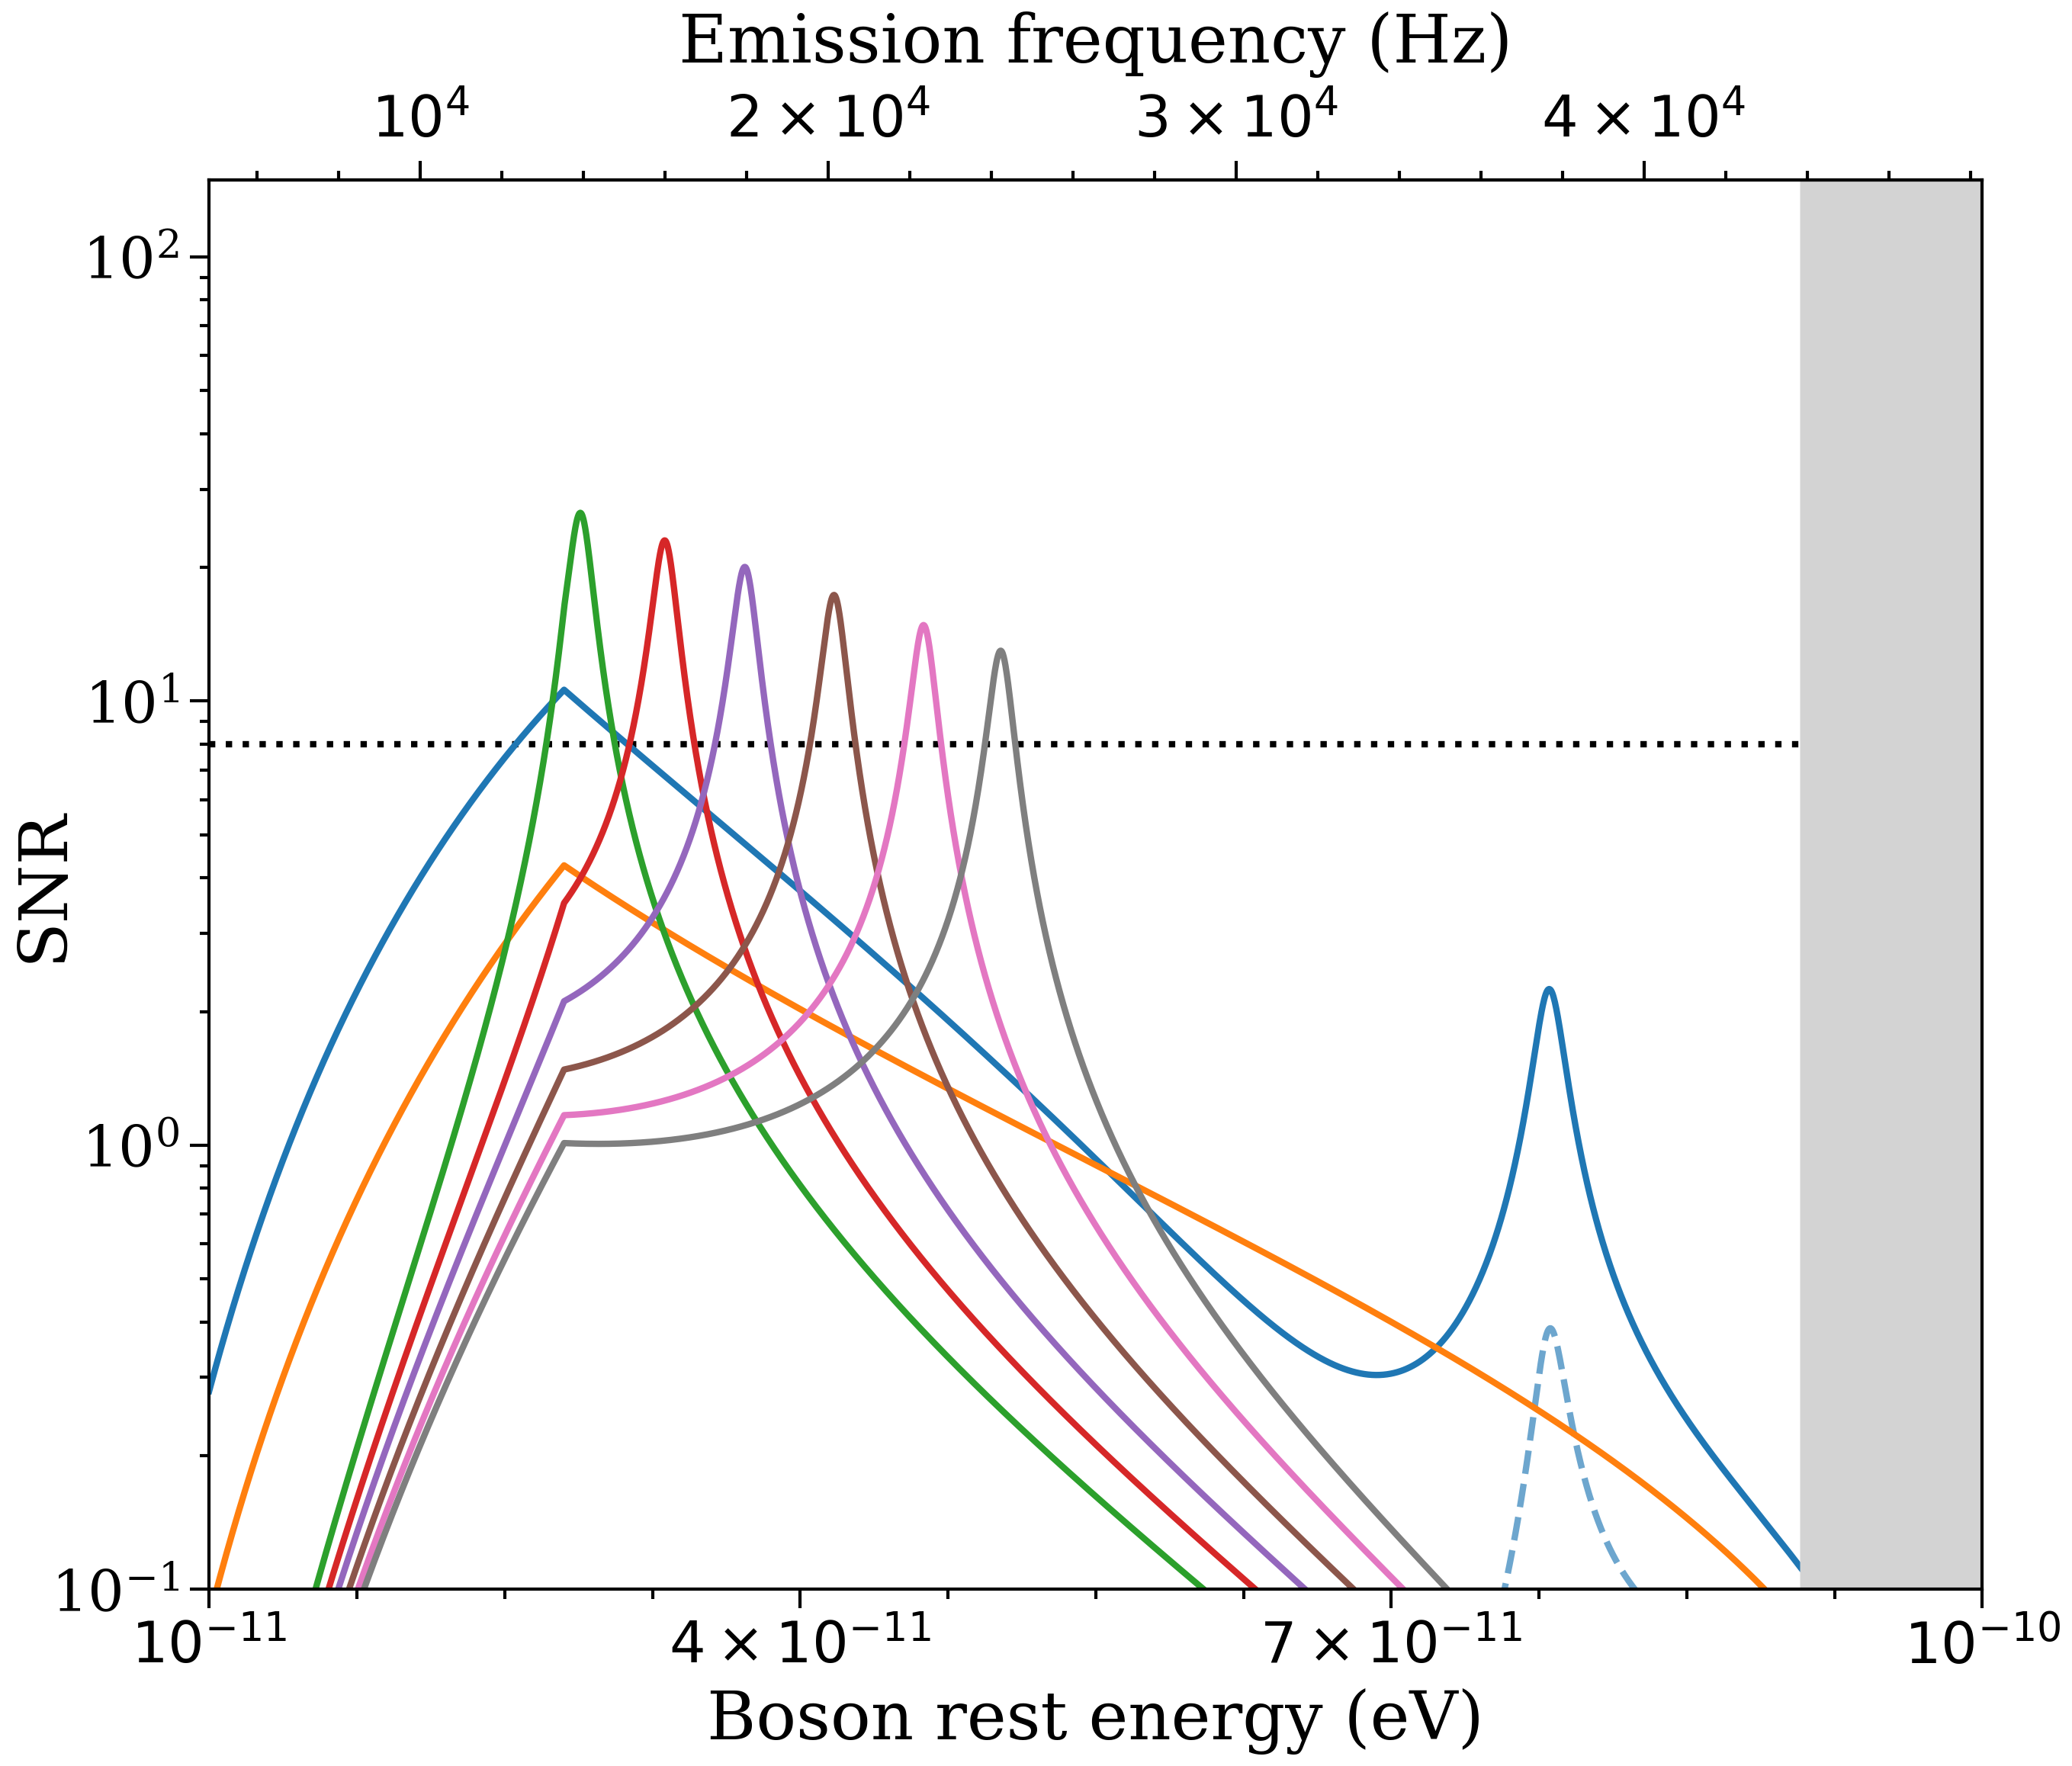

In [7]:
# Create labels to use in graph:
labels = ['aLIGO','GEO600']
for phi in srm_phi_vector:
    labels.append(f'$\phi={phi}$')

# Create Graph:
plot_SNR(u, SNR_list_vector, SNR_list_scalar, labels, LOGuEnd)